# Лабораторная работа №4: "Линейные модели, SVM и деревья решений".

## Загрузка датасета

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

In [2]:
data = pd.read_csv('laptop_price_preprocessed.csv')
data.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram_GB,OpSys,Weight_kg,Price_euros,ScreenType,...,ScreenRes,Cpu_type,Cpu_GHz,Gpu_producer,Gpu_model,Memory1_GB,Memory1_type,Memory2_GB,Memory2_type,Memory2
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,IPS Panel Retina Display,...,2560x1600,Intel Core i5,2.3,Intel,Iris Plus Graphics 640,128,SSD,0,-,-
1,2,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,-,...,1440x900,Intel Core i5,1.8,Intel,HD Graphics 6000,128,Flash Storage,0,-,-
2,3,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,...,1920x1080,Intel Core i5 7200U,2.5,Intel,HD Graphics 620,256,SSD,0,-,-
3,4,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,IPS Panel Retina Display,...,2880x1800,Intel Core i7,2.7,AMD,Radeon Pro 455,512,SSD,0,-,-
4,5,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,IPS Panel Retina Display,...,2560x1600,Intel Core i5,3.1,Intel,Iris Plus Graphics 650,256,SSD,0,-,-


## Кодирование категориальных признаков

In [3]:
category_cols = ['Memory1_type', 'Memory2_type', 'Company', 'Product', 'TypeName', 'OpSys', 
                 'ScreenType', 'Cpu_type', 'Gpu_producer', 'Gpu_model']

print('Количество уникальных значений\n')
for col in category_cols:
    print(f'{col}: {data[col].unique().size}')

Количество уникальных значений

Memory1_type: 4
Memory2_type: 4
Company: 19
Product: 618
TypeName: 6
OpSys: 9
ScreenType: 21
Cpu_type: 93
Gpu_producer: 4
Gpu_model: 110


In [4]:
remove_cols = ['Product', 'Gpu_model', 'Cpu_type']
for col in remove_cols:
    category_cols.remove(col)
data = pd.get_dummies(data, columns=category_cols)

In [5]:
data.drop(remove_cols, axis=1, inplace=True)
data.drop(['laptop_ID', 'ScreenRes', 'Memory2'], axis=1, inplace=True)
data.describe()

,Inches,Ram_GB,Weight_kg,Price_euros,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,...,ScreenType_Quad HD+,ScreenType_Quad HD+ / Touchscreen,ScreenType_Touchscreen,ScreenType_Touchscreen / 4K Ultra HD,ScreenType_Touchscreen / Full HD,ScreenType_Touchscreen / Quad HD+,Gpu_producer_AMD,Gpu_producer_ARM,Gpu_producer_Intel,Gpu_producer_Nvidia
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,15.034880,8.443200,2.046152,1132.177480,1897.272000,1072.256000,2.303856,447.180800,174.675200,0.055200,...,0.002400,0.012000,0.025600,0.000800,0.000800,0.000800,0.133600,0.000800,0.552000,0.313600
std,1.416838,5.121929,0.669436,703.965444,491.854703,283.172078,0.502772,367.670259,411.340426,0.228462,...,0.048951,0.108929,0.158002,0.028284,0.028284,0.028284,0.340358,0.028284,0.497488,0.464142
min,10.100000,2.000000,0.690000,174.000000,1366.000000,768.000000,0.900000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,600.425000,1600.000000,900.000000,2.000000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,8.000000,2.040000,985.000000,1920.000000,1080.000000,2.500000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,15.600000,8.000000,2.310000,1489.747500,1920.000000,1080.000000,2.700000,512.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,18.400000,64.000000,4.700000,6099.000000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.head()

,Inches,Ram_GB,Weight_kg,Price_euros,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,...,ScreenType_Quad HD+,ScreenType_Quad HD+ / Touchscreen,ScreenType_Touchscreen,ScreenType_Touchscreen / 4K Ultra HD,ScreenType_Touchscreen / Full HD,ScreenType_Touchscreen / Quad HD+,Gpu_producer_AMD,Gpu_producer_ARM,Gpu_producer_Intel,Gpu_producer_Nvidia
0,13.3,8,1.37,1339.69,2560,1600,2.3,128,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13.3,8,1.34,898.94,1440,900,1.8,128,0,1,...,0,0,0,0,0,0,0,0,1,0
2,15.6,8,1.86,575.00,1920,1080,2.5,256,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15.4,16,1.83,2537.45,2880,1800,2.7,512,0,0,...,0,0,0,0,0,0,1,0,0,0
4,13.3,8,1.37,1803.60,2560,1600,3.1,256,0,0,...,0,0,0,0,0,0,0,0,1,0


## Корреляционный анализ

In [7]:
print('Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука')
best_params = data.corr()['Price_euros'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.35]
best_params

Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука


Ram_GB                 0.743141
TypeName_Notebook      0.555495
ScreenWidth            0.553660
ScreenHeight           0.550213
Memory1_type_SSD       0.505318
ScreenType_-           0.435191
Cpu_GHz                0.431697
Memory1_type_HDD       0.425687
TypeName_Gaming        0.377151
Gpu_producer_Nvidia    0.351031
Name: Price_euros, dtype: float64

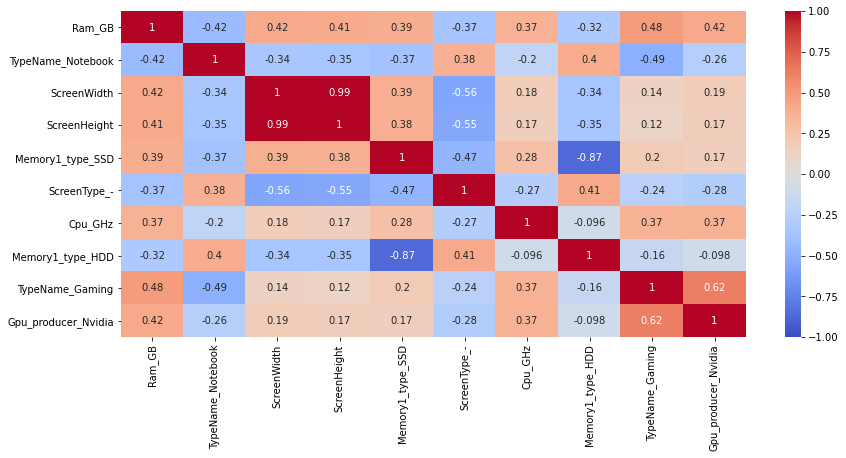

In [8]:
plt.figure(figsize=(14, 6))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [9]:
best_params = best_params.drop(['ScreenHeight', 'Memory1_type_SSD', 'ScreenType_-', 'Gpu_producer_Nvidia']) #, 'Gpu_producer_Nvidia', , 'TypeName_Gaming', 'Memory2_type_-', 'Memory2_type_HDD'], inplace=True)

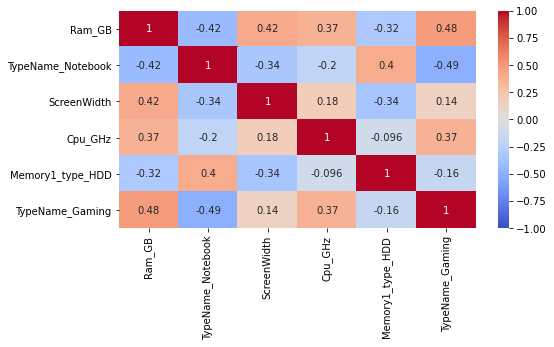

In [10]:
plt.figure(figsize=(8, 4))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

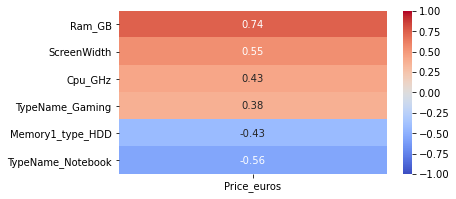

In [11]:
plt.figure(figsize=(6, 3))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'Price_euros')].corr()['Price_euros'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

## Разделение выборки на обучающую и тестовую

In [12]:
y = data['Price_euros']
X = data[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

## Линейная регрессия

In [13]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [14]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)
print_metrics(y_test, y_pred_linear)

R^2: 0.6770754057292072
MSE: 139827.8138334042
MAE: 275.17093485469525


## Пополиномиальная регрессия

In [15]:
poly_model = PolynomialFeatures(degree=3)
x_train_poly = poly_model.fit_transform(x_train)
x_test_poly = poly_model.fit_transform(x_test)
linear_model = LinearRegression()
linear_model.fit(x_train_poly, y_train)
y_pred_poly = linear_model.predict(x_test_poly)
print_metrics(y_test, y_pred_poly)

R^2: 0.679477609592945
MSE: 138787.64866603096
MAE: 264.41254443760585


## SVM

In [16]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

,Ram_GB,TypeName_Notebook,ScreenWidth,Cpu_GHz,Memory1_type_HDD,TypeName_Gaming
count,8.750000e+02,8.750000e+02,8.750000e+02,8.750000e+02,8.750000e+02,8.750000e+02
mean,5.468641e-17,1.715453e-16,8.263231e-18,-6.127302e-16,-4.491645e-17,-9.478133e-17
std,1.000572e+00,1.000572e+00,1.000572e+00,1.000572e+00,1.000572e+00,1.000572e+00
min,-1.213107e+00,-1.136035e+00,-1.057818e+00,-2.751903e+00,-6.484247e-01,-4.401414e-01
25%,-8.342815e-01,-1.136035e+00,-5.922109e-01,-5.895875e-01,-6.484247e-01,-4.401414e-01
50%,-7.663095e-02,8.802544e-01,4.451633e-02,3.932830e-01,-6.484247e-01,-4.401414e-01
75%,-7.663095e-02,8.802544e-01,4.451633e-02,7.864312e-01,1.542199e+00,-4.401414e-01
max,1.053048e+01,8.802544e-01,3.864880e+00,2.555598e+00,1.542199e+00,2.271997e+00


In [17]:
params = {'C': np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 15, 1)])}
svm_model = SVR(kernel='linear')
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

{'C': 11.0}


In [18]:
best_svm_model = grid_cv.best_estimator_
best_svm_model = SVR(kernel='linear', C=11)
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

R^2: 0.6670420012232607
MSE: 144172.32348755666
MAE: 272.96301929727315


## Дерево решений

In [19]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeRegressor(random_state=3)
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 5}


In [20]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

R^2: 0.6842074880923352
MSE: 136739.5898250473
MAE: 258.4878614139572


In [21]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

Ram_GB: 0.746
Cpu_GHz: 0.121
TypeName_Notebook: 0.073
ScreenWidth: 0.03
Memory1_type_HDD: 0.017
TypeName_Gaming: 0.014


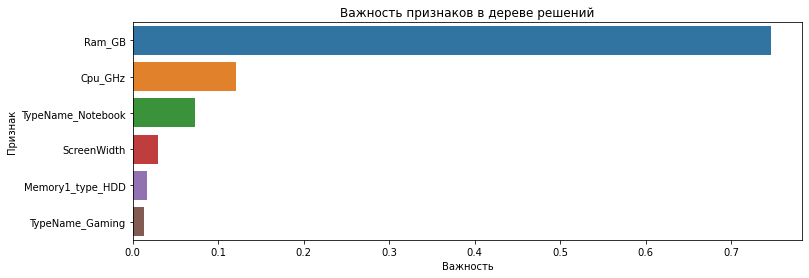

In [22]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

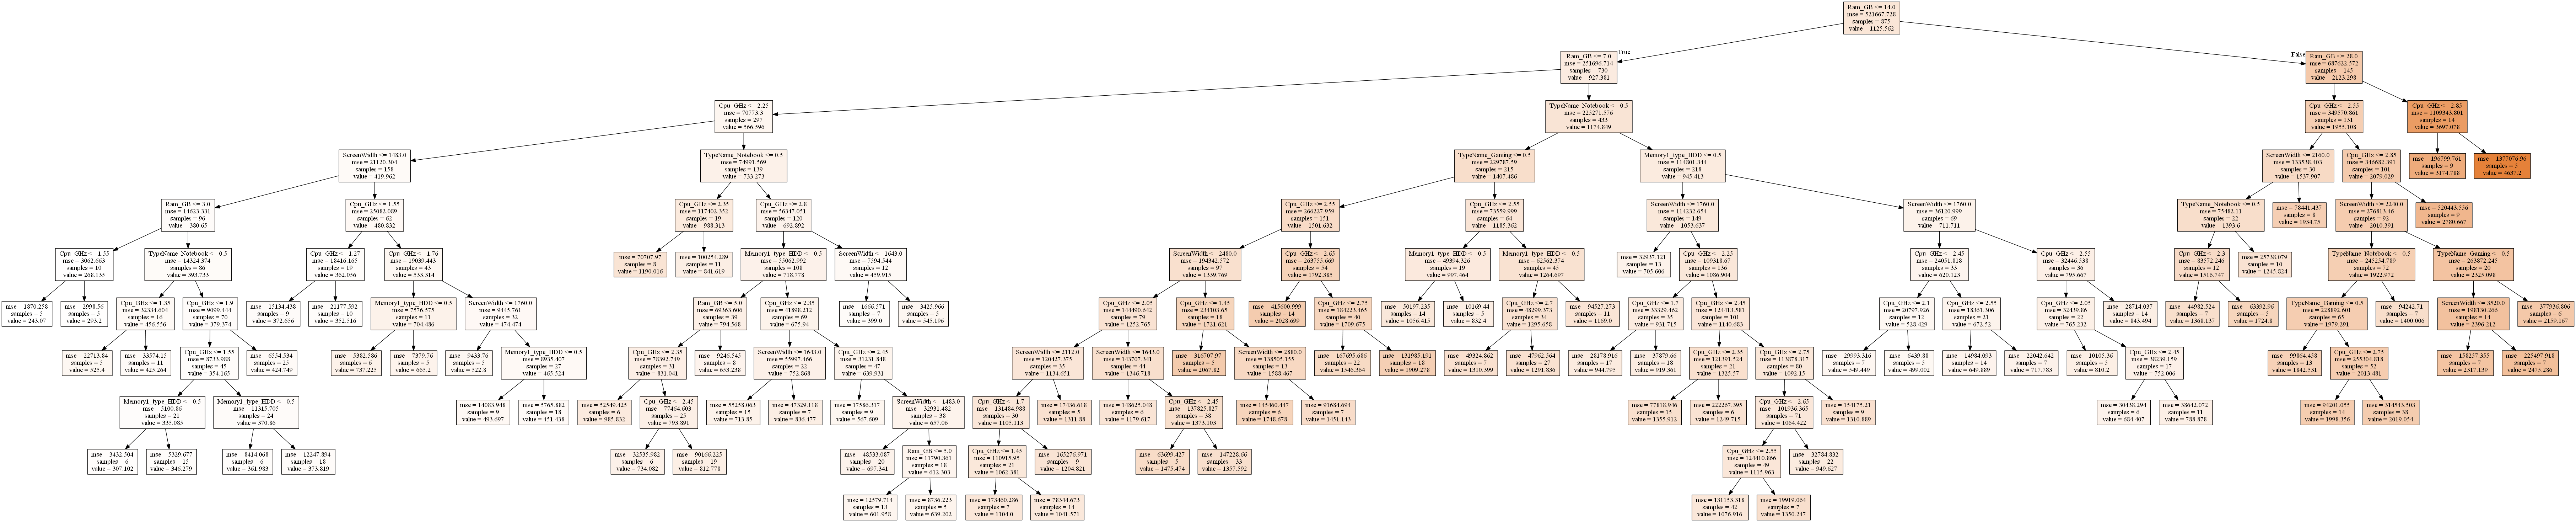

In [23]:
export_graphviz(best_tree, feature_names=best_params.index, filled=True, out_file='tree.dot')
!dot -Tpng tree.dot -o tree.png
Image(filename='tree.png')

## Сравнение моделей

In [24]:
print('Линейная регрессия')
print_metrics(y_test, y_pred_linear)

print('\nПолиномиальная регрессия')
print_metrics(y_test, y_pred_poly)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Линейная регрессия
R^2: 0.6770754057292072
MSE: 139827.8138334042
MAE: 275.17093485469525

Полиномиальная регрессия
R^2: 0.679477609592945
MSE: 138787.64866603096
MAE: 264.41254443760585

Метод опорных векторов
R^2: 0.6670420012232607
MSE: 144172.32348755666
MAE: 272.96301929727315

Дерево решений
R^2: 0.6842074880923352
MSE: 136739.5898250473
MAE: 258.4878614139572
